# Expanding the slow SSM in Kolmogorov flow

We find the one-dimensional slow spectral submanifold (SSM) of the  stable fixed point $\omega_{1}$ in Kolmogorov flow at $Re=11$. 



Working with Fourier coefficients, the slow SSM is parametrized as

$$\hat{\omega} = \mathbf{W}(\xi)$$.

This computation is carried out automatically by [SSMTool](https://github.com/haller-group/SSMTool-2.4), which returns the coefficients of the Taylor expansion of $\mathbf{W}(\xi)$ and the reduced dynamics on the SSM as
$$    \hat{\omega}(k_x, k_y) = \mathbf{W}(\xi) = \sum_{k}\mathbf{W}_k \xi^k
$$

$$
    \dot{\xi} = R(\xi) = \sum_{k}R_k \xi^k
$$

## Recover SSMTool results

In [56]:
import numpy as np
from scipy.io import loadmat
import sympy as sy
p1= sy.symbols('p_1')
var = np.array([p1]).reshape(1,1)
import taylor_to_pade

In [57]:
from taylor_to_pade.matlab_integration import *
from taylor_to_pade.approximant import TaylorSeries, PadeApproximant

In [58]:
def approximate_mfd(xi, order, omega_list):
    omega = xi**0 * omega_list[0]
    for o in range(1,order):
        omega += xi**o * omega_list[o]
    return omega

In [59]:
def extract_w0_new(matt):
    mat_array = []
    matt = matt['W_0'][0]
    order = len(matt)
    for i in range(order):
        dictt = {}
        if matt['coeffs'][i].shape[0]>0:
            dictt['coeffs'] = np.array(matt['coeffs'][i])
            dictt['ind'] = np.array(matt['ind'][i], dtype= int)
        else:
            dictt['coeffs'] = []
            dictt['ind'] = []
        mat_array.append(dictt)
    return mat_array


In [60]:
def extract_r0_new(matt):
    mat_array = []
    matt = matt['R_0'][0]
    order = len(matt)
    for i in range(order):
        dictt = {}
        if matt['coeffs'][i].shape[0]>0:
            dictt['coeffs'] = np.array(matt['coeffs'][i])
            dictt['ind'] = np.array(matt['ind'][i], dtype= int)
        else:
            dictt['coeffs'] = []
            dictt['ind'] = []
        mat_array.append(dictt)
    return mat_array


In [63]:
Re = 11.

mat = loadmat("unstable_mfd_fourier_data_sept21_re_11__0_.mat")
mat['W_0'] = mat['W0']
mat['R_0'] = mat['R0']
del mat['R0']
del mat['W0']
matt = mat['W_0'][0]
W0 = extract_w0_new(mat) # get parametrization
R0 = extract_r0_new(mat) # get reduced dyn

In [64]:
# assemble symbolic expression for reduced dyn
reduced_dyn = p1*0
R0[0]['coeffs'] = R0[0]['coeffs'].item().toarray()
coeffs_numpy = [0]
for r in R0:
    ind_ = r['ind'][0][0]
    coeff = r['coeffs'][0][0].real
    reduced_dyn += coeff * p1**ind_
    coeffs_numpy.append(coeff)

We also recover the simulated trajectories on the heteroclinic orbit

In [66]:

dat = hdf5storage.read(filename = "Kolmogorov_coefficients_around_fp.mat")
w_0_ft = dat['w0']
plus = dat['plus']
minus = dat['minus']

coeffs_param = [w_0_ft]
for w in W0:
    coeff = w['coeffs']
    coeffs_param.append(np.squeeze(coeff))


## Visualize the manifold 

We select the wave numbers that are most dominant in the flow. 

In [151]:
indices = np.arange(0, 576, 1)
where_lam = np.abs(plus[:,0])>1

In [152]:
indices[where_lam]

array([ 4, 20])

In [157]:
ky.ravel()[4]

tensor(4., dtype=torch.float64, grad_fn=<SelectBackward0>)

The indices 4 and 20 corresponds to the mean flow: 


In [163]:
print("k_x=%s, k_y = %s" %(kx.ravel()[4].item(), ky.ravel()[4].item()))

k_x=0.0, k_y = 4.0


In [164]:
print("k_x=%s, k_y = %s" %(kx.ravel()[20].item(), ky.ravel()[20].item()))

k_x=0.0, k_y = -4.0


Same with the nontriv fp:

In [166]:
ind1, ind2, ind3 = 20, 28, 44

The indices 28 and 44 denote the appearence of $x$-dependent modifications of the mean flow. 

In [182]:
from scipy.interpolate import pade

In [186]:
p, q = pade(coeffs_numpy, 5, 5)


In [193]:
coeffs_param = [w_0_ft]
coeffs_param_28 = [w_0_ft[28]]
coeffs_param_20 = [w_0_ft[20]]
coeffs_param_44 = [w_0_ft[44]]

for w in W0:
    coeff = w['coeffs']
    coeffs_param.append(np.squeeze(coeff))
    coeffs_param_28.append(np.squeeze(coeff)[28])
    coeffs_param_20.append(np.squeeze(coeff)[20])
    coeffs_param_44.append(np.squeeze(coeff)[44])

p_28, q_28 = pade(coeffs_param_28, 5, 5)
p_20, q_20 = pade(coeffs_param_20, 5, 5)
p_44, q_44 = pade(coeffs_param_44, 5, 5)


/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_pade.py:63: LinAlgWarning: Ill-conditioned matrix (rcond=2.65409e-29): result may not be accurate.
  pq = linalg.solve(C, an)
/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_pade.py:63: LinAlgWarning: Ill-conditioned matrix (rcond=1.96998e-30): result may not be accurate.
  pq = linalg.solve(C, an)


In [259]:
xis_numpy_tay = np.linspace(-300, 400, 3000).reshape(-1,1)
taylor = approximate_mfd(xis_numpy_tay, 16, coeffs_param)
xis_numpy_pade = np.linspace(-600, 800, 3000).reshape(-1,1)


Let us also add the linear approximation, i.e., the spectral subspace itself

In [279]:
subspace = coeffs_param[0] + xis_numpy_pade * coeffs_param[1]

In [330]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 13, "font.family": "serif",})
plt.rcParams.update({'text.latex.preamble':r"\usepackage{amsmath}"})

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


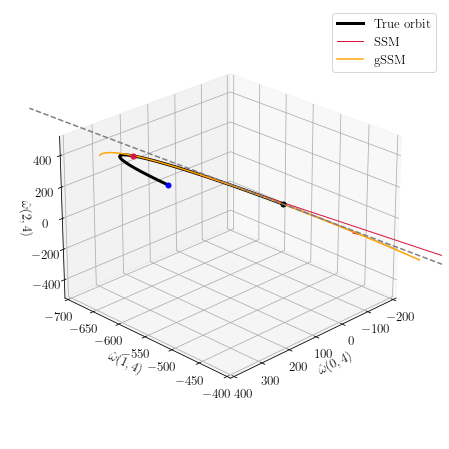

In [331]:

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')
ax.plot(plus[ind2, :], plus[ind1, :], -plus[ind3, :], c= 'black', linewidth = 3, label = 'True orbit')
ax.plot(minus[ind2, :], minus[ind1, :], -minus[ind3, :], c= 'black',  linewidth = 3)
ax.plot(taylor[:, ind2], taylor[:, ind1], -taylor[:,ind3], c= 'crimson',  linewidth = 1,  label = 'SSM')

ax.plot(p_28(xis_numpy_pade) / q_28(xis_numpy_pade),
        p_20(xis_numpy_pade) / q_20(xis_numpy_pade),
        -p_44(xis_numpy_pade) / q_44(xis_numpy_pade), c= 'orange',   label = 'gSSM')

ax.plot(plus[ind2,0], plus[ind1,0], -plus[ind3,0], '.', markersize =10, c = 'Crimson')
ax.plot(minus[ind2,-1], minus[ind1,-1], -minus[ind3,-1], '.', markersize =10, c = 'Black')
ax.plot(plus[ind2,-1], plus[ind1,-1], -plus[ind3,-1], '.', markersize =10, c = 'Blue')
ax.plot(subspace[:,ind2], subspace[:,ind1], -subspace[:,ind3], '--', c='grey')
ax.legend()
ax.set_xlabel('$\hat{\omega}(0, 4)$')
ax.set_ylabel('$\hat{\omega}(1, 4)$')
ax.set_zlabel('$\hat{\omega}(2, 4)$')


ax.set_xlim(-200, 400)
ax.set_ylim(-700, -400)
ax.set_zlim(-500, 500)
ax.view_init(elev=25, azim=45, roll=0)
ax.set_box_aspect(None, zoom=0.85)

In [339]:

red_color = [0.70567316, 0.01555616, 0.15023281, 1.        ]

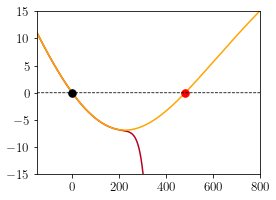

In [340]:
fig = plt.figure(figsize = (4, 3))
ax3 = fig.add_subplot(111)

xis_numpy = np.linspace(-900, 1500, 3000).reshape(-1,1)
order = 16
red_dyn = approximate_mfd(xis_numpy, order, coeffs_numpy).T
ax3.plot(1*np.squeeze(xis_numpy), 1 *np.squeeze(red_dyn), '-', c=red_color)
fixedpoint = np.roots(coeffs_numpy[:order][::-1])
real_fixedpoints = fixedpoint[fixedpoint.imag == 0]
filt = np.logical_and(real_fixedpoints<800, real_fixedpoints>-800)
fp =real_fixedpoints[filt]
ax3.plot(1* np.squeeze(xis_numpy) , 1 * p(np.squeeze(xis_numpy)) / q(np.squeeze(xis_numpy)),  '-', c= 'Orange')
ax3.plot(0,0,'.', c='black', markersize = 15.)
ax3.plot(xis_numpy[1725,0],0.,'.', c='red', markersize = 15.)

ax3.set_ylim(-15, 15)

ax3.set_xlim(-150, 800)
#ax3.grid()
ax3.plot(np.squeeze(xis_numpy), np.squeeze(xis_numpy)*0, '--', linewidth = 0.8, c='black')
plt.savefig('kolmogorov_dynamics_1.pdf', bbox_inches='tight')

/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_544/2700493847.py:4: RuntimeWarning: overflow encountered in power
  omega += xi**o * omega_list[o]
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_544/2700493847.py:4: RuntimeWarning: invalid value encountered in add
  omega += xi**o * omega_list[o]


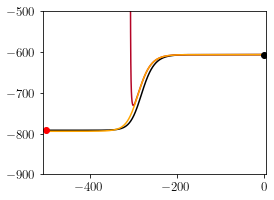

In [358]:
ff = plt.figure(figsize = (4,3))
ax = ff.add_subplot(111)
ax.plot(-teval, minus[20,:][::-1], c= 'black')
ic_xi = 1e-5
## integrate reduced model backward:
red_lam = lambda t,x: approximate_mfd(x, order, coeffs_numpy).T
ic_nn = approximate_mfd(ic_xi, o, coeffs_param).T
forward_red = solve_ivp(red_lam, [0, time_length], [ic_xi], t_eval=teval).y
backward_red = solve_ivp(red_lam, [0,-time_length], [ic_xi], t_eval=-teval)

forward_red_par = approximate_mfd(forward_red.T, order, coeffs_param).T
backward_red_par = approximate_mfd(backward_red.y.T, order, coeffs_param).T
ax.plot(backward_red.t, backward_red_par[20,:], '-', c=red_color)
    
rade_red = lambda t, x :  p(np.squeeze(x)) / q(np.squeeze(x))
backward_pade_red = solve_ivp(rade_red, [0,-time_length], [ic_xi], t_eval=-teval)
backward_red_pade_par = p_20(np.squeeze(backward_pade_red.y)) / q_20(np.squeeze(backward_pade_red.y))
ax.plot(-teval, backward_red_pade_par, '-', c='orange')
ax.plot(0, minus[20,-1], '.', c='black', markersize = 12)
ax.plot(-500, minus[20,0], '.', c='red', markersize = 12)

ax.set_ylim(-900, -500)
ax.set_xlim(-506, 6)
plt.savefig('kolmogorov_time_traj.pdf', bbox_inches='tight')
